# Comparisson Between Gradient Descent with Backtracking Line Search and the Trust Region Method

In [1]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt
%matplotlib inline

from pdb import set_trace

## Algorithms

In [2]:
# Backtracking line search for GD 
def backtrack(z, f, grad, mu, alp = 2, beta = 0.5):    
    '''
    Input: 
        z:     Current location
        f:     Objective function 
        grad:  Gradient 
        alp:   Warm start parameter
        beta:  Step size decay parameter 
        mu:    Step size from previous iteration

    Output: 
        mu: step size 
    '''    
    mu = alp*mu

    while f(z - mu*grad) > f(z) - 0.25*mu*np.linalg.norm(grad)**2:
        # decrease step size
        mu *= beta
        
    return mu 

In [3]:
# Implementation of Gradient Descent with backtracking line search
def BGD(x0, gradf, fun=lambda z: 0, niter=1000,eps=1e-6):    
    '''
    Input: 
        x0:  intilalization 
        gradf:  gradient function takes position argument 
        fun: objective function
        niter: Number of iterations 

    Itermediate: 
        grad: Gradient
        mu:   Step size, initialized as 1       
    Output: 
        z: final solution 
        out: objective values per iterations 
    '''
    out = np.empty(niter+1)
    z = x0.copy() 
    mu = 1
    out[0] = fun(z)
    
    # Gradient Descent with line search
    for itr in range(niter):
        grad = gradf(z)
        # compute stepsize using backtrack
        mu = backtrack(z, fun, grad, mu)
        # update z in gradient direction
        z = z - mu * grad
        # store function value
        out[itr+1] = fun(z)
        
        # check stopping criterion
        if abs(out[itr+1] - out[itr]) < eps:
            itr = itr + 1
            break
    
    return z, out[:itr+1]

In [4]:
# Implementation of Power method for eigen vector computation
def PM(A0, ninner=1000, eps=1e-6):
    '''
    Input: 
        A0:     Matrix of interest (N by N)
        niter: Maximum number of iterations
        eps:   Tolerance 
    Intermediate: 
        N:     Number of columns of A
    Output: 
        u1:  leading eigen vector (unique up to sign) 
    '''   
    N = A0.shape[1]
    v1 = np.ones((N,1))
    v1_new = v1
    
    for itr in range(ninner):
        # update v1
        _v = A0 @ v1
        # v1 = [V]v1 / ||[V]v1||_2
        v1_new = _v / np.linalg.norm(_v[:,0])
        # Stopping crieterion ||v_{k+1} - v_k||/ ||v_k|| < eps
        if (np.linalg.norm(v1_new - v1) / np.linalg.norm(v1) < eps):
            v1 = v1_new
            break
        v1 = v1_new
    # ensure v1 has the correct norm
    v1 = np.sqrt(np.linalg.norm(np.dot(A0,v1)))*v1
    return v1

In [5]:
#Trusted Region Subproblem
# Solving the TRM subproblem is SDP and cvx solver 
# source : https://www.cvxpy.org/examples/basic/sdp.html

def TRM_sub(f_q, block_m, delta):
    '''
    Input:
        f_q:     qudratic approximation to the objective function, takes direction -> approximation
        delta:   Trust region radius 
        block_m: The block matrix used for SDP
    Intermediate: 
        X:       CVX variable 
    Output: 
        dr:      Direction vector 
    '''
    # matrix variable
    X = cp.Variable(block_m.shape,symmetric=True)
    # problem constraints
    constraints = [cp.trace(X) <= delta**2 + 1,
                    X >> 0, 
                    X[-1, -1] == 1]
    # minimization problem
    prob = cp.Problem( cp.Minimize(cp.trace(block_m @ X)) , constraints )
    # solve problem
    prob.solve()
    
    # leading eigenvector of X -> our step direction
    dr = PM(X.value)
    # ignore last entry of dr (should always be 1)
    dr = dr[:-1]
    
    # check for the sign of the eivenvector with biggest descent
    if (f_q(-dr) < f_q(dr)):
        dr = -dr
    
    return dr

In [20]:
#Trusted Region Method 
# Solving the TRM subproblem is SDP and cvx solver
def TRM(x0, gradf, hessf, fun = lambda z:0, niter=1000, delta=0.1, eta_s = 0.2, eta_vs = 0.8, gamma_i=2, gamma_d=0.5, eps=1e-6): 
    '''
    Input:
        x0:      Intilalization         
        gradf:    Gradient function of objective function: takes location -> Gradient Vector
        hessf:    Hessian function of Objective function:  takes location -> Hessian Matrix
        fun:     Objective function
        niter:   maximum umber of iterations
        rho:     quality of reduction 
        delta:   Trust region radius 
        eta_vs:  Threshold if rho>eta_vs fun approximation is considered very successful
        eta_s:   Threshold if rho<eta_s fun approximation is considered unsuccessful 
        gamma_i: Parameter increases delta
        gamma_d: Parameter decreases delta 
        
    Intermediate:
        grad :   Gradient for current iterate 
        hess :   Hessian Matrix for current iterate
        block_m: The block matrix used for SDP
        dr:      moving direction 
        fun_q:   qudratic approximation to the objective function, takes direction -> approximation
        
    Output: 
         out: objective values per iterations 
         x:      Estimated parameter 
    '''
    x = x0.copy()
    out = np.empty(niter+1)
    out[0] = fun(x)
    
    # quadratic approximation to the objective function
    fun_q = lambda d, z : fun(z) + np.dot(d.T, gradf(z)) + 0.5*np.dot(d.T, hessf(z)@d)
    # block matrix used for SDP
    block_m = lambda z : np.block( [ [hessf(z),  gradf(z)], [gradf(z).T , 2 * fun(z)] ])
    
    for itr in range(niter):
        # direction computed using SDP
        dr = TRM_sub(lambda d : fun_q(d, x) , block_m(x) , delta)
        
        # measure of how good of a descent direction dr is
        rho = (fun(x) - fun(x+dr)) / (fun(x) - fun_q(dr,x))
        
        
        # if the direction was unsuccessful, don't update x, shrink delta
        if rho<eta_s:
            delta *= gamma_d
        # check stopping condition
        elif abs(fun(x)-fun(x+dr)) < eps:
            out[itr+1] = fun(x)
            break
        # if the direction was very successful
        elif (rho > eta_vs):
            x += dr
            delta *= gamma_i
        # if the direction was moderately successful
        else:
            x += dr
            
        out[itr+1] = fun(x)
            
    return x, out[:itr+1]

## Generating the Data

In [18]:
np.random.seed(0)

n = 5
m = 50
x_true = np.random.randn(n,1)

A = np.random.randn(n,m)
y = (A.T@x_true)**2

## Test out the Algorithms

In [21]:
Obj  = lambda z: (0.25/m)*(np.linalg.norm(y-(A.T@z)**2)**2)
Grad = lambda z: A@(((A.T@z)**3-(A.T@z)*y))/m
Hess = lambda z: (A@(((3*((A.T@z)**2)-y))*A.T))/m

x_TRM, out_TRM = TRM(np.ones((n,1)), gradf = Grad,  hessf = Hess, fun = Obj)
x_grad, out_BGD = BGD(np.ones((n,1)), gradf = Grad, fun = Obj)

print(len(out_TRM))
print(len(out_BGD))

8
18


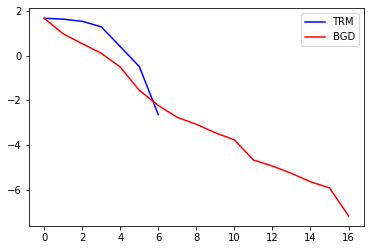

In [22]:
# Converence to the optimal value 
plt.plot(np.arange(len(out_TRM)-1),np.log10(np.array(out_TRM[:-1]-out_TRM[-1])),'b')
plt.plot(np.arange(len(out_BGD)-1),np.log10(np.array(out_BGD[:-1]-out_BGD[-1])),'r')

plt.legend((r'TRM', r'BGD'), loc = 'upper right')